# Implement GLM and Contrast Function
A generalized linear model is used to find where brain activity changes given different tasks
The contrast function compares the brain activity between target and general task.

We are interested in the following contrast:
- Differentiate brain region activity between target and general task during audio condition
- Differentiate brain region activity between target and general task during visual condition
- Differentiate brain region activity between audio and visual condition after contrast is applied to both conditions

In [41]:
# import dependencies
from nilearn.glm.first_level import FirstLevelModel
import numpy as np
import nibabel as nib
import nilearn.masking as masking
from nilearn.image import mean_img
import os
import glob
import pandas as pd
from nilearn.plotting import plot_design_matrix

In [42]:
# Implement glm base model
def fit_glm(fmri_img, events_data, tr):
    """ 
    Fit a glm to the fmri data
    """

    mask = masking.compute_epi_mask(
        fmri_img,
        lower_cutoff = 0.1,
        upper_cutoff = 0.9,
        connected = False,
        opening = False
    )

    model = FirstLevelModel(
        t_r=tr,
        mask_img = mask,
        standardize = True,
        minimize_memory = True,
    )
    
    glm = model.fit(fmri_img, events = events_data)
    
    return glm

In [43]:
# Categorize stimuli into target and general task
def categorize_stimuli(events_data, data_path):
    """ 
    Categorize stimuli based on the filename patterns
    For visual data: 'inh' = general task, 'sel' = target task
    events_data: pandas dataframe pulled from the events.tsv file
    data_path: path to the visual folder 
    """
    print("data_path: ", data_path)
    if 'visual' in data_path: # if there is a data file with visual in the path
        if 'inh' in data_path:
            events_data['condition'] = 'general' # inhibition task
        elif 'sel' in data_path:
            events_data['condition'] = 'target' # selection task
    
    print("inhibition tasks: ", events_data[events_data['condition'] == 'general'])
    print("selection tasks: ", events_data[events_data['condition'] == 'target'])
    
    return events_data

In [44]:
# Implement contrast function
def contrast_glm_stimuli(glm, events_data, file_path, contrast_def = {'target': 1, 'general': -1}): 
    """ 
    Apply a contrast to the glm results 
    """
    events = categorize_stimuli(events_data, file_path)

    # convert dictionary to array
    conditions = sorted(contrast_def.keys()) # create a list of conditions
    contrast_vector = np.array([contrast_def[cond] for cond in conditions])

    print("Conditions: ", conditions) 
    print("Contrast vector: ", contrast_vector)

    contrast = glm.compute_contrast(contrast_vector)
    return contrast

def contrast_glm_conditions(glm, contrast_def = {'target': 1, 'general': -1}):
    """ 
    Apply a contrast to the glm results
    """
    conditions = sorted(contrast_def.keys()) # create a list of conditions
    contrast_vector = np.array([contrast_def[cond] for cond in conditions])
    
    contrast = glm.compute_contrast(contrast_vector)
    return contrast

In [45]:
# function to get design matrix
def create_design_matrix(glm):
    """ 
    Create a design matrix for the glm results
    """
     # get design matrix
    design_matrix = glm.design_matrices_[0]
    # set keys for the design matrix
    design_matrix.columns = ['constant', 'target', 'general', 'drift_1', 'drift_2', 'drift_3']
    
    return design_matrix


In [46]:
# Define parameters 
data_path = "../data/visual" # path to data folder
file_path = "../data/visual" # path to all individual data files
fmri_data = "../results/visual/cleaned_data_visual.nii.gz" #TODO: need to add audio data
fmri_img = nib.load(fmri_data)
tr = 1.5 # test with visual data

/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:129: UserWarning: 'trial_type' column not found in the given events data.
  warnings.warn(
/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: false-go, response_time_avg, errors_total, false-no_go, block, block_type_intended, block_type_performed, correct_total, comments, NR
  warnings.warn(


columns:  ['dummy', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'constant']
data_path:  ../data/visual
Conditions:  ['general', 'target']
Contrast vector:  [-1  1]


/Users/jaslavie/Desktop/attention/venv/lib/python3.11/site-packages/nilearn/glm/contrasts.py:108: UserWarning: t contrasts should be of length P=6, but it has length 2. The rest of the contrast was padded with zeros.
  reg = regression_result[label_].Tcontrast(con_val)


<Axes: label='conditions', ylabel='scan number'>

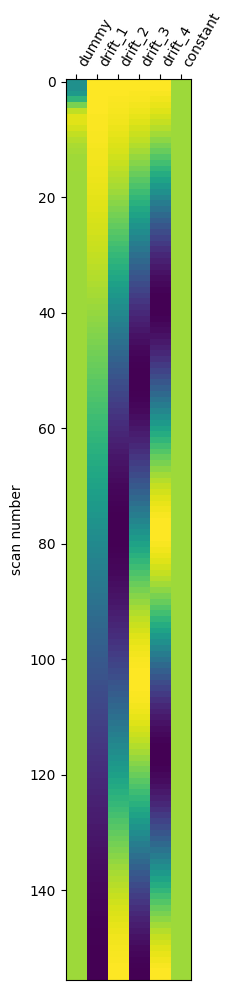

In [47]:
# function to run contrast and glm
def run_glm_contrast(fmri_img, data_path, tr):
    """ 
    Run the glm on the fmri data and apply contrast
    """
    pattern = os.path.join(data_path, 'sub-*/func/*events.tsv')
    events_files = glob.glob(pattern, recursive=True)

    if not events_files:
        raise ValueError(f"No events files found in {pattern}")
    
    events_data = pd.read_csv(events_files[0], sep='\t')
    
    # Get GLM object
    glm = fit_glm(fmri_img, events_data, tr)
    
    # Get design matrix
    design_matrix = glm.design_matrices_[0]
    design_matrix_columns = design_matrix.columns.tolist()
    print("columns: ", design_matrix_columns)
    design_matrix.columns = ['dummy', 'drift_1', 'drift_2', 'drift_3', 'drift_4', 'constant' ]
    
    # Compute contrasts
    contrast_stimuli = contrast_glm_stimuli(glm, events_data, data_path)
    contrast_conditions = contrast_glm_conditions(glm)
    
    return glm, design_matrix, contrast_stimuli, contrast_conditions

# Run GLM and get results
glm, design_matrix, contrast_stimuli, contrast_conditions = run_glm_contrast(fmri_img, data_path, tr)

# Plot design matrix (not the contrast)
plot_design_matrix(design_matrix)